In [1]:
# Learning point 1: end to end LightGBM with more visualizations of output
# Learning point 2: model importance scores

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.inspection import permutation_importance
import shap

# Load your data
data = pd.read_csv('credit_card.csv')
X = data.copy().drop(['Class'],axis=1) # the way we use time variable is wrong for time series analysis, here, we pretend it is just another numerical input
feature_names = X.columns.tolist()
y = data['Class'].copy()

# Part 1: Data Preparation and Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add more data preprocessing when needed.

# Part 2: Hyperparameter Tuning using GridSearchCV
model = lgb.LGBMClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 5, 6],
    # Add other parameters if needed
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Fitting 2 folds for each of 27 candidates, totalling 54 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300}
Best score: 0.8260191098093821


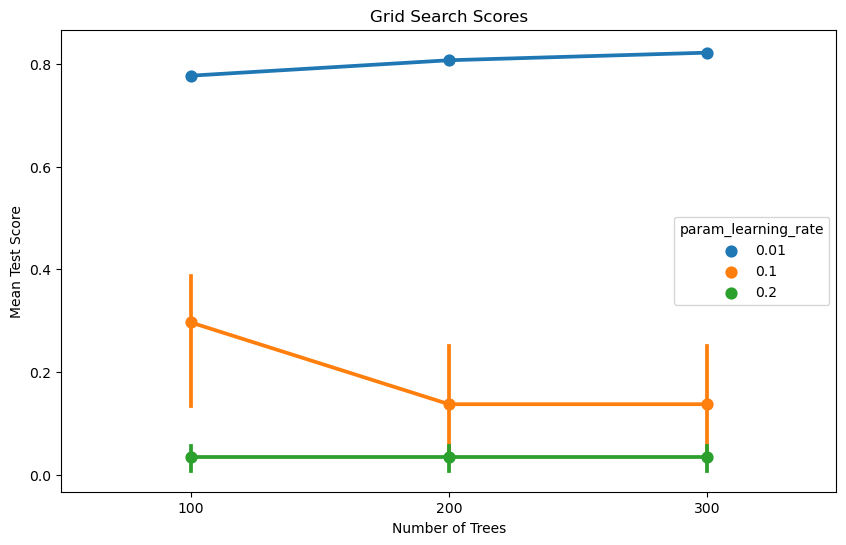

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.


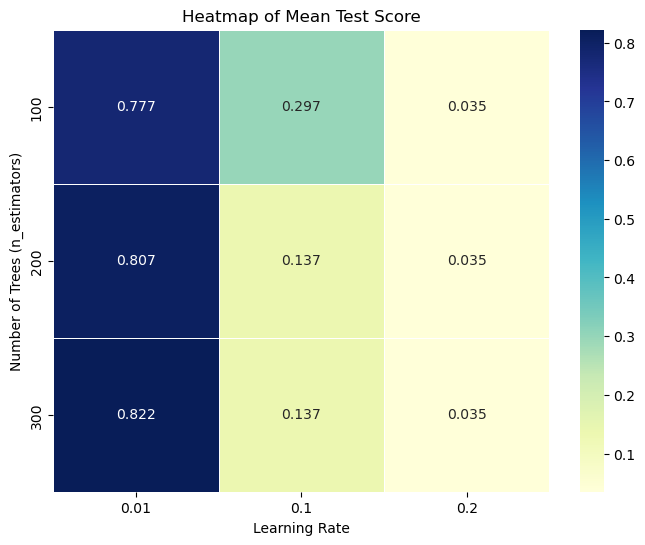

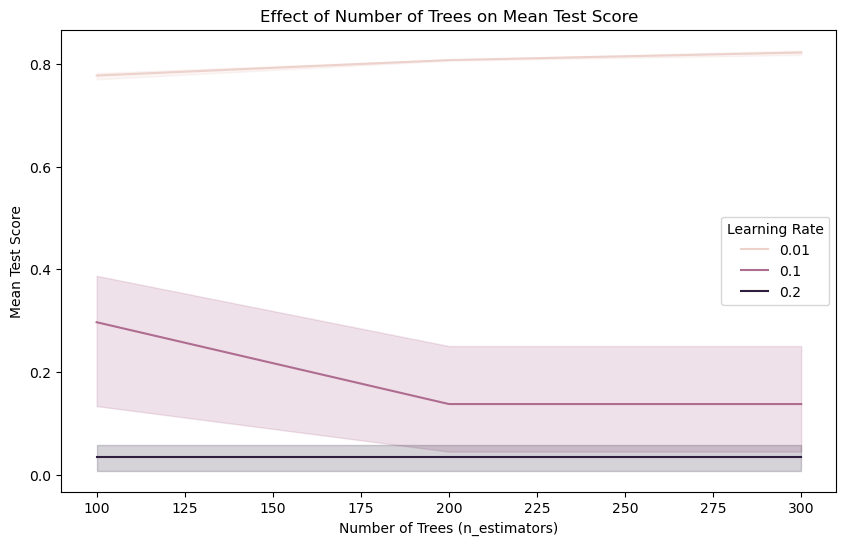

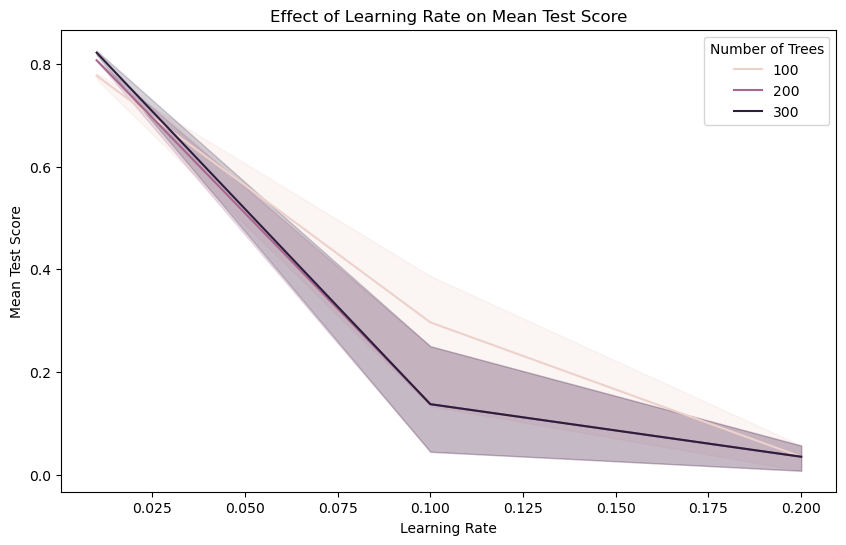

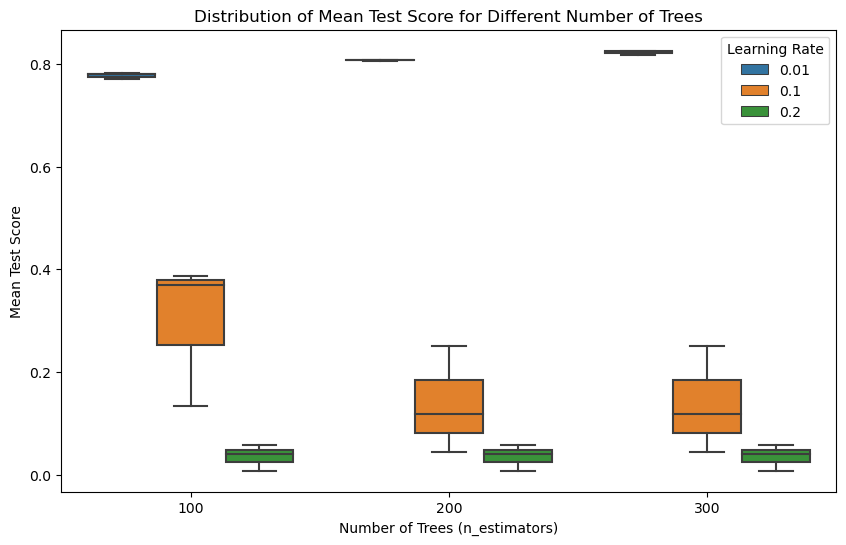

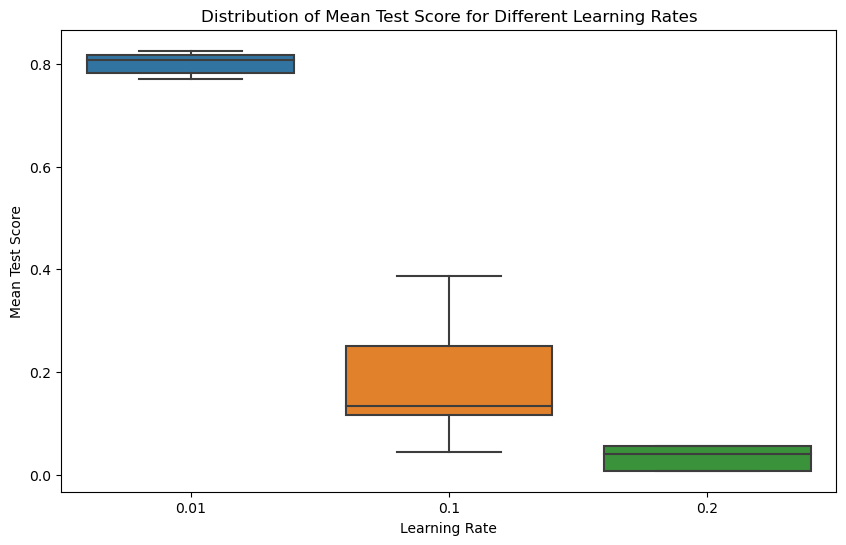

In [2]:
# Part 3: Visualization of Results
results = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))

# plot1
sns.pointplot(x="param_n_estimators", y="mean_test_score", hue="param_learning_rate", data=results)
plt.xlabel('Number of Trees')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Scores')
plt.show()

# Plot2: heatmap
# Aggregate the results by taking the mean of 'mean_test_score' for each combination of 'param_n_estimators' and 'param_learning_rate'
aggregated_results = results.groupby(['param_n_estimators', 'param_learning_rate'])['mean_test_score'].mean().reset_index()

# Create a pivot table from the aggregated results
pivot_table = aggregated_results.pivot('param_n_estimators', 'param_learning_rate', 'mean_test_score')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", linewidths=.5, cmap='YlGnBu')
plt.title('Heatmap of Mean Test Score')
plt.xlabel('Learning Rate')
plt.ylabel('Number of Trees (n_estimators)')
plt.show()

# plot3
# Plot for 'n_estimators', you can change to other parameter names,
plt.figure(figsize=(10, 6))
sns.lineplot(x="param_n_estimators", y="mean_test_score", hue="param_learning_rate", data=results)
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Mean Test Score')
plt.title('Effect of Number of Trees on Mean Test Score')
plt.legend(title='Learning Rate')
plt.show()

# Plot for 'learning_rate'
plt.figure(figsize=(10, 6))
sns.lineplot(x="param_learning_rate", y="mean_test_score", hue="param_n_estimators", data=results)
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Score')
plt.title('Effect of Learning Rate on Mean Test Score')
plt.legend(title='Number of Trees')
plt.show()

#plot4
# Boxplot for 'n_estimators'
plt.figure(figsize=(10, 6))
sns.boxplot(x="param_n_estimators", y="mean_test_score", hue="param_learning_rate", data=results)
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Mean Test Score')
plt.title('Distribution of Mean Test Score for Different Number of Trees')
plt.legend(title='Learning Rate')
plt.show()

# Boxplot for 'learning_rate'
plt.figure(figsize=(10, 6))
sns.boxplot(x="param_learning_rate", y="mean_test_score", data=results)
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Score')
plt.title('Distribution of Mean Test Score for Different Learning Rates')
plt.show()

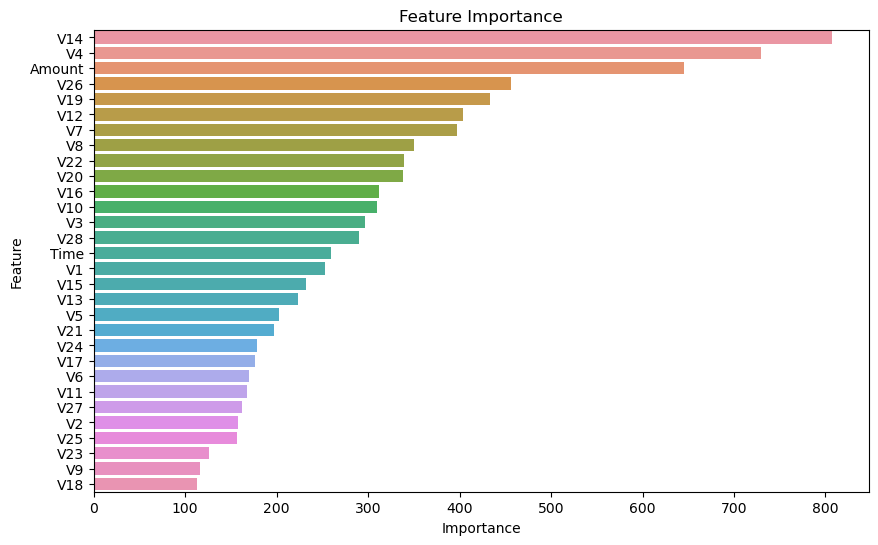

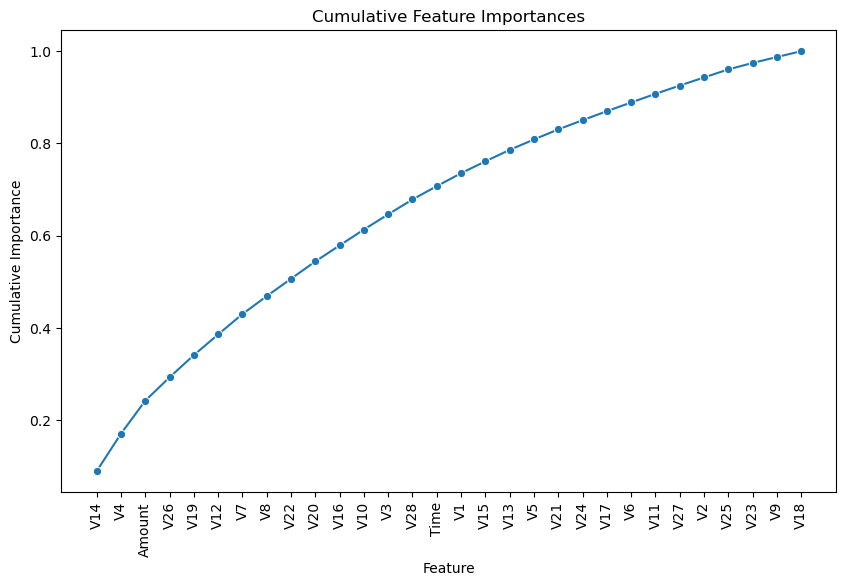

In [3]:
# Part 4a: Get feature importances
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = best_model.feature_importances_

# Convert feature importances into a DataFrame
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame to find out the most important features
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Visualization 1: Bar Plot of Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Visualization 2: Plotting feature importances cumulatively
feature_importances_df['Cumulative Importance'] = feature_importances_df['Importance'].cumsum() / feature_importances_df['Importance'].sum()
plt.figure(figsize=(10, 6))
sns.lineplot(data=feature_importances_df, x='Feature', y='Cumulative Importance', marker='o')
plt.xticks(rotation=90)
plt.title('Cumulative Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Cumulative Importance')
plt.show()

Text(0.5, 0, 'Permutation Importance')

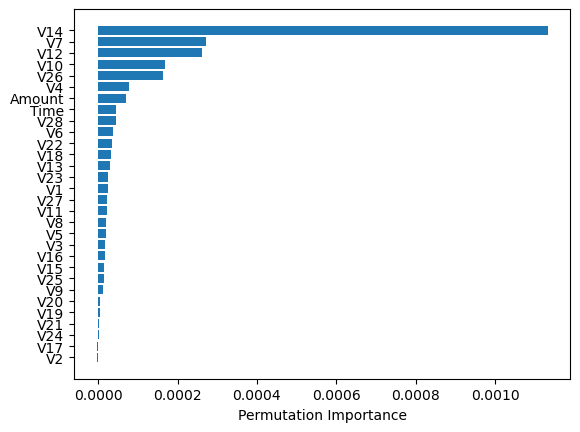

In [4]:
# Part 4b: Model Explainability (slowest among 5)
# Permutation Importance
perm_importance = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=30)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


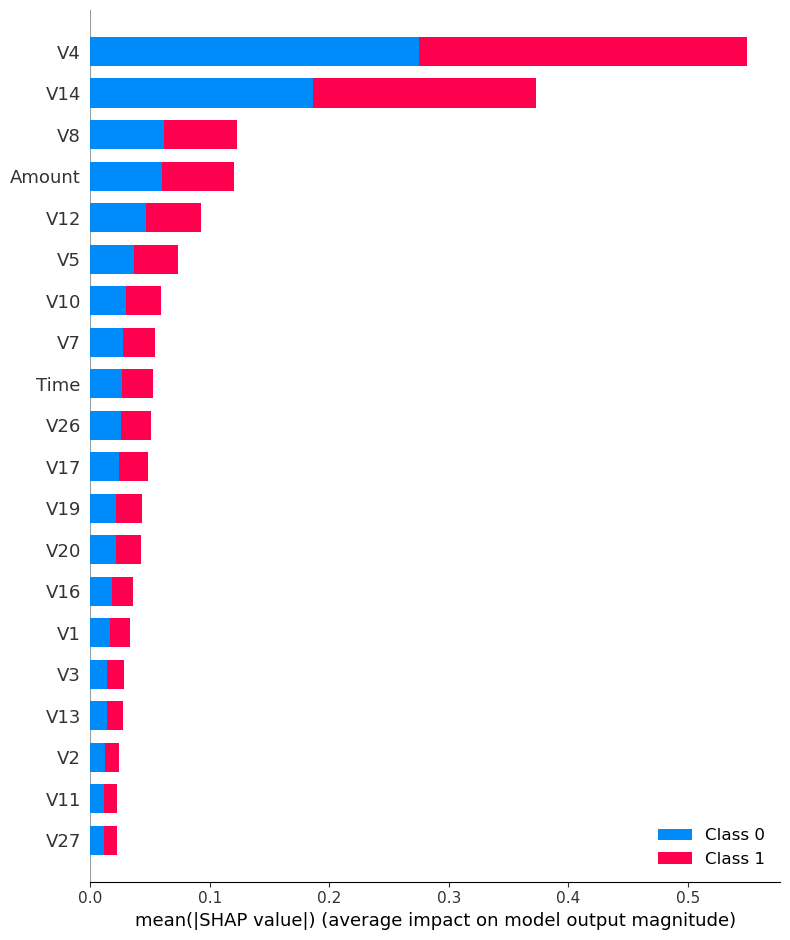

In [5]:
# Part 4c: SHAP Values
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_scaled)
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns)

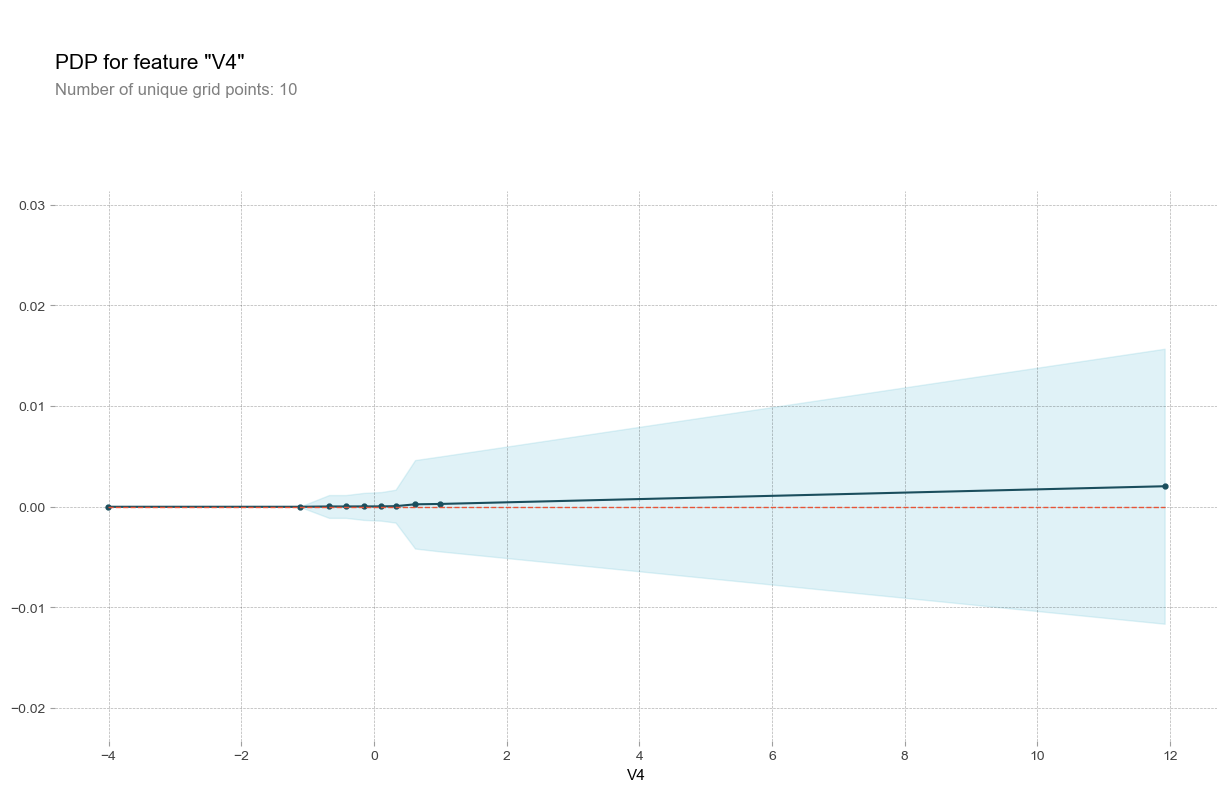

In [6]:
# Part 4d: Partial Dependence Plots
from pdpbox import pdp, info_plots
import matplotlib.pyplot as plt
import pandas as pd  # Make sure to import pandas

# pick the feature you want to see how it affects Y
feat_name = 'V4'

# Ensure that the model_features parameter is correctly set as a list of feature names
model_features = feature_names  

# Convert X_train_scaled back to a DataFrame if it's not already
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=model_features)

# Ensure the dataset is in the correct format (DataFrame)
pdp_dist = pdp.pdp_isolate(
           model=best_model,
           dataset=X_train_scaled_df,  # Now using the DataFrame version
           model_features=model_features,
           feature=feat_name
)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

In [7]:
# Plot 4e: LIME (Local Interpretable Model-agnostic Explanations)
# Codes of this part works, but results are strange in this case. Will update later.
import lime
import lime.lime_tabular

# Convert X_train to a 2D numpy array if it's not already
X_train_values = X_train.values if isinstance(X_train, pd.DataFrame) else X_train

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_values,
    mode='classification',
    training_labels=y_train,
    #sample_around_instance=True,
    discretize_continuous=False,
    feature_names=feature_names
)

# Choose a specific instance to explain
instance_to_explain = X_test.iloc[1].values  # Get the instance values

# The instance needs to be in the shape (1, number_of_features)
# Use numpy's reshape method to ensure this
instance_to_explain = instance_to_explain.reshape(1, -1)  # Reshaping to (1, number_of_features)

# Make sure that the predict function returns probability distributions
# The predict_fn expects a function, so if best_model.predict_proba is not compatible directly,
# you might need to define a custom predict function
def predict_fn(x):
    return best_model.predict_proba(x)

explanation = explainer.explain_instance(
    data_row=instance_to_explain[0],  # Pass the instance
    predict_fn=predict_fn  # Use the custom predict function
)

explanation.show_in_notebook(show_table=True, show_all=False)